In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns


# To-do:
- Create target variable (adopted_user: someone that logged in thrice in a seven-day period)
- EDA
- Feature Engineering
- Modeling

In [2]:
df_users = pd.read_csv('takehome_users.csv',encoding='latin-1')


In [3]:
df_eng = pd.read_csv('takehome_user_engagement.csv')
df_eng.time_stamp = pd.to_datetime(df_eng.time_stamp)

In [23]:
df_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,0


In [4]:
df_users.creation_time = pd.to_datetime(df_users.creation_time)
df_users.last_session_creation_time = pd.to_datetime(df_users.last_session_creation_time, unit='s')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


Check for duplicates:

In [5]:
df_users[df_users.duplicated(keep=False)].object_id.sum()

0

In [6]:
df_eng[df_eng.duplicated(keep=False)].user_id.sum()

0

Let's look at the missing values in `last_session_creation_time`:

In [7]:
df_users[df_users.last_session_creation_time.isna()].object_id

7            8
8            9
11          12
14          15
15          16
         ...  
11975    11976
11977    11978
11984    11985
11992    11993
11993    11994
Name: object_id, Length: 3177, dtype: int64

In [8]:
df_eng[df_eng.user_id == 8]

,time_stamp,user_id,visited


It seems that users that have missing value in `last_session_creation_time` might have created the account but never logged in, since they are not found in the usage table (`df_eng`). Since we are trying to predict user adoption, we can label all these users as 0 (False) for the target variable.

Based on this, let's create our target variable:

In [21]:
df_users['adopted'] = 0
for i in df_eng.user_id.unique():
    if sum(df_eng[df_eng.user_id==i].resample('7D', on='time_stamp').visited.count()>2) >0:
        df_users.loc[df_users.object_id == i,'adopted'] = 1
    else: df_users.loc[df_users.object_id == i,'adopted'] = 0

And so, we have our target variable:

In [22]:
df_users.adopted.value_counts()

0    10528
1     1472
Name: adopted, dtype: int64

Our dataset is imbalanced. We need to keep this in mind when creating our model.

# EDA

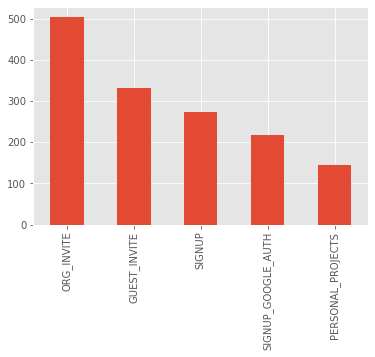

In [41]:
df_users[df_users.adopted == 1].creation_source.value_counts().plot(kind='bar')
plt.show()

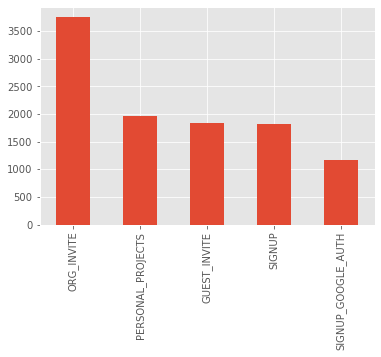

In [43]:
df_users[df_users.adopted == 0].creation_source.value_counts().plot(kind='bar')
plt.show()

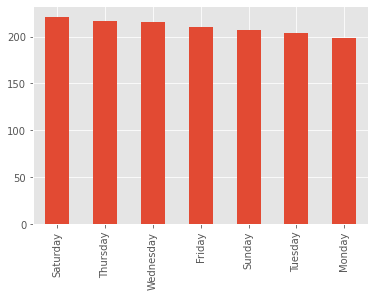

In [47]:
df_users[df_users.adopted == 1].creation_time.dt.day_name().value_counts().plot(kind='bar')
plt.show()

Day of the week doesn't seem to explain the variation of our target variable.

Let's look at each month:

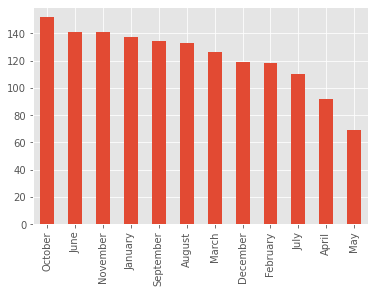

In [48]:
df_users[df_users.adopted == 1].creation_time.dt.month_name().value_counts().plot(kind='bar')
plt.show()

Day of the week doesn't seem to explain the variation of our target variable either. Unless we compare May to October, but even then, it doesn't seem relevant

Maybe by year:

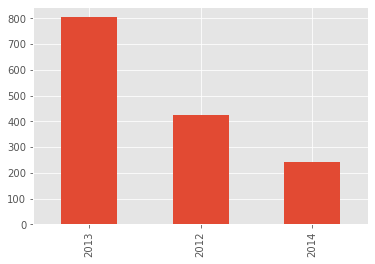

In [49]:
df_users[df_users.adopted == 1].creation_time.dt.year.value_counts().plot(kind='bar')
plt.show()

It seems that if users created their account in 2013 they are more likely to be `adopted`, but if we are creating a model to predict user adoption, we will only get new data from the present time, so taking into account the year might not be benefitial for us.

# Feature Engineering

Let's create some predictor variables:
- `invited` will be a binary variable where 1 = invited by other user, and 0 = not invited by other user
- `in_org` will be a binary variable where 1 = belongs to organization, and 0 = does not belong to organization

In [30]:
df_users['invited'] = df_users.invited_by_user_id.isna().apply(lambda x: 0 if x else 1)
df_users['in_org'] = df_users.org_id.apply(lambda x: 1 if x != 0  else 0)
df_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited,in_org
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0,1,1
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,0,0,1
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0,1,1
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,0,0,1


Now, let's create our dataset to be used for our model:

In [68]:
from sklearn.utils import resample

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# concatenate our training data back together
df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
# Separate majority and minority classes
df_majority = df_users[df_users.adopted==0]
df_minority = df_users[df_users.adopted==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=1234) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.adopted.value_counts()

1    10528
0    10528
Name: adopted, dtype: int64

In [69]:
y = df_upsampled.adopted
X = df_upsampled[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited', 'in_org']]
X = pd.concat([X, pd.get_dummies(df_upsampled['creation_source'])], axis=1)
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited,in_org,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,1,1,1,0,0,0,0
2,0,0,1,1,0,1,0,0,0
3,0,0,1,1,1,0,0,0,0
4,0,0,1,1,1,0,0,0,0
5,0,0,1,1,1,0,0,0,0


In [70]:
print(y.shape,X.shape)

(21056,) (21056, 9)


# Modeling

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [73]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [74]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.46      0.51      2672
           1       0.54      0.66      0.59      2592

    accuracy                           0.56      5264
   macro avg       0.56      0.56      0.55      5264
weighted avg       0.56      0.56      0.55      5264



In [75]:
pd.DataFrame(rf.predict(X_test)).value_counts()

1    3140
0    2124
dtype: int64

In [76]:
rf_grid = RandomForestClassifier(random_state=42)
grid_params = {
        'min_samples_leaf': [5,50,100],
        'max_depth' : [10,100, None],
        'n_estimators': [100,1000]
        }
rf_grid_cv = GridSearchCV(rf_grid, param_grid=grid_params, cv=3, n_jobs=-1)

In [77]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 100, None],
                         'min_samples_leaf': [5, 50, 100],
                         'n_estimators': [100, 1000]})

In [78]:
print(classification_report(y_test, rf_grid_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.46      0.51      2672
           1       0.54      0.66      0.59      2592

    accuracy                           0.56      5264
   macro avg       0.56      0.56      0.55      5264
weighted avg       0.56      0.56      0.55      5264



In [79]:
print(rf_grid_cv.best_params_)
print(rf_grid_cv.best_estimator_)

{'max_depth': 10, 'min_samples_leaf': 50, 'n_estimators': 1000}
RandomForestClassifier(max_depth=10, min_samples_leaf=50, n_estimators=1000,
                       random_state=42)


# XGBoost

In [80]:
import xgboost as xgb
xg_cl = xgb.XGBClassifier(objective='reg:logistic', n_estimators=100, seed=123)

In [81]:
xg_cl.fit(X_train, y_train)
xgb_pred = xg_cl.predict(X_test)

In [82]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.58      0.45      0.51      2672
           1       0.54      0.66      0.60      2592

    accuracy                           0.56      5264
   macro avg       0.56      0.56      0.55      5264
weighted avg       0.56      0.56      0.55      5264

